<h1> <b> The battle of the neighborhoods </b></h1>
     Final Capstone project of module 10 in IBM professional Data Science Certificate / IBM applied Data Science Certificate

<h2><b> New York City </b></h2>

<img src="https://media.timeout.com/images/105632328/630/472/image.jpg">

<h3> <b> Introduction/Business problem </b> </h3>

Whenever people visit or move to a new place the have so many question the want answer too regard the place, its neighborhood, the demographic of the area. All of this information plays a crucial role of new investors willing to invest in particular area because with such information a business owner will be able to know which customer to target and which area needs more coverage. For new visitors with such information it make it easier form them to find places they desire to visit such as favorite restaurant in the area they are visiting.

With this  experiment we aim to analysis the neighborhoods of New York city in order to find Italian restaurant, best Italian restaurant in the area and which are is open for business (area with less or no Italian restaurant in which willing investors can invest in.

Targeted audience for this project can be new or existing investors, visitors visiting New York City which have a desire in eating Italian food and or with the desired of enjoying takeouts from Italian restaurant in the nearest are they are visiting. This project save all of the above mentioned stakeholders time that can be lost finding all of this information from Google or spending time trying to find all of this information from the Internet.  

<h3> <b>Data </b></h3>

The project uses two database/dataset to accomplish its goal.

1) New York dataset  which can be downloaded from https://cocl.us/new_york_dataset  link. The dataset contains borough of New York with with their neighborhoods and Latitude and longitude. This will help use explore each neighborhood to locate Italian restaurant.


2) Foursquare API:
This API has a database of more than 105 million places. This project would use Four-square API as its prime data gathering source. Many organizations are using to geo-tag their photos with detailed info about a destination, while also serving up contextually relevant locations for those who are searching for a place to eat, drink or explore. This API provides the ability to perform location search, location sharing and details about a business. Foursquare users can also use photos, tips and reviews in many productive ways to add value to the results.

<b>Dependences</b> <br>
• Pandas - Library for Data Analysis<br>
• NumPy – Library to handle data in a vectorized manner<br>
• JSON – Library to handle JSON files<br>
• Geopy – To retrieve Location Data<br>
• Requests – Library to handle http requests<br>
• Matplotlib – Python Plotting Module<br>
• Sklearn – Python machine learning Library<br>
• Folium – Map rendering Library<br>

In [1]:
# Libraries Import statements

# vectors
import numpy as np

# data analysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json 
# library to handle requests
import requests 

# plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

# k-means for clustering 
from sklearn.cluster import KMeans 

# convert an address into latitude and longitude values
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

# map rendering library
!conda install -c conda-forge folium=0.5.0 --yes
import folium 

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

<h4> Using Foursquare API </h4>
1) Create a variable to store Foursquare client ID .
<br> 2) Create a variable to store Foursquare client secrete key.
<br> 3) Create a variable to store the version

In [2]:
CLIENT_ID = 'KGWVZLX1JOX4VMUSLY3VC1VTLABY22ZUVNNF2H4TMKBL5UUB'
CLIENT_SECRET ='CWV4CGZLT5TK4BOOQIML31IN0WGCPBJ40QNICU0GKIGQF5QX'
VERSION = '20180605'

In [3]:
# A function to intract with FourSquare API and get top venues across the city, the function takes a Latitude and Logitude then return top Venues within the radius 100
def get_venues(lat,lng):
        LIMIT=100 
        radius=100
        
        # define the url to fetch the data from foursquare API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(            
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)

        # return the data collected
        output = requests.get(url).json()
        venue=output["response"]['groups'][0]['items']
        venue_details=[]
        for row in venue:
            try:
                venue_id=row['venue']['id']
                venue_name=row['venue']['name']
                venue_category=row['venue']['categories'][0]['name']
                venue_details.append([venue_id,venue_name,venue_category])
            except KeyError:
                pass

        column_names=['ID','Name','Category']
        df = pd.DataFrame(venue_details,columns=column_names)
        return df

In [4]:
# Get the venues full details with the ratings of the venue
def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(            
        venue_id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df 
        

<h3> <b>Methodology </b></h3>

<h4><b>Data Preparation and Data understanding </b></h4>


In [5]:
# reading data from the dataset 
url='https://cocl.us/new_york_dataset' # url pointing to dataset to be read from
col_name = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] # dataframe column names

In [6]:
# define a function that returns a dataframe containing the borough, neigborhood, and geolacation of NY 
def locate_neigh():
    resp=requests.get(url).json()
    data=resp['features'] # get all data
    df_data = pd.DataFrame(columns=col_name) # dataframe enstatiation
    
    # iterate through out the data to find each neighborhoods, name, bourgh, latitude, and logitude
    for row in data:
        borough = row['properties']['borough'] 
        neighborhood = row['properties']['name']
        
        # neigborhood geolocation
        latlon = row['geometry']['coordinates']
        lat =latlon[1]
        lon =latlon[0]
        
        # add all data into the dataframe
        df_data = df_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood,
                                          'Latitude': lat,
                                          'Longitude':lon}, ignore_index=True)
    return df_data
    

In [7]:
ny_data=locate_neigh()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


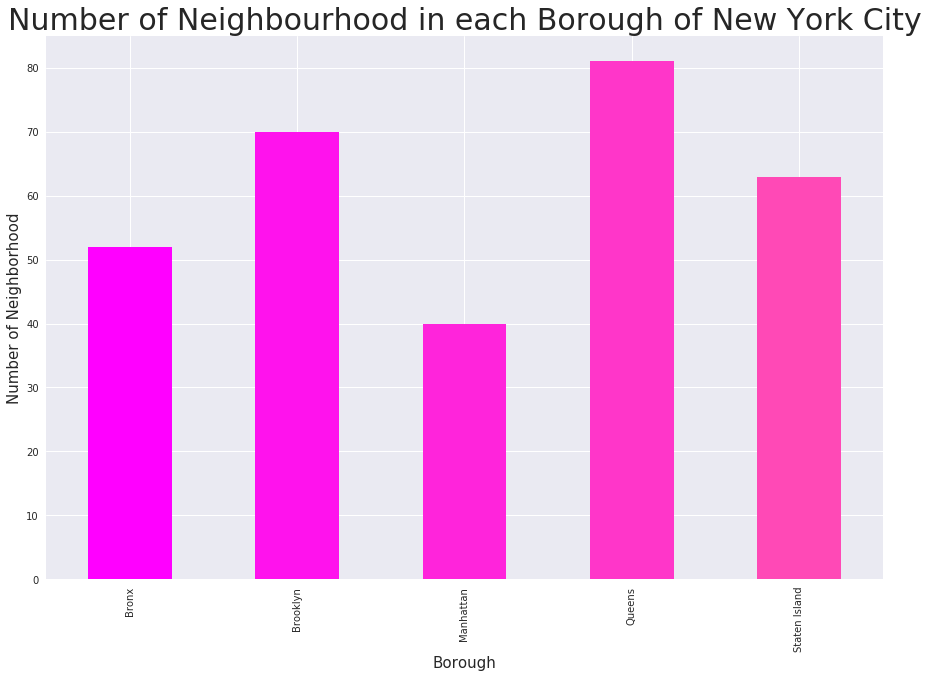

In [8]:
# plot showing how many neighborhooh each borough has.
plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('seaborn')

color = plt.cm.spring(np.linspace(0, 1, 15))

# x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Neighborhood', fontsize=15)
ny_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar',color = color, figsize = (15, 10))

plt.title('Number of Neighbourhood in each Borough of New York City',fontsize = 30)

plt.xticks(rotation = 90)
plt.show()

<h3> <b>Result </b></h3>

<h4><b> Find all Hotels in New York</b></h4> 
<b>Foursqaure API in action </b>

In [9]:
# Create dataframe to store all Italian restaurant in New York City
df_italian = pd.DataFrame(columns=['Borough', 'Neighborhood', 'ID','Name'])
# counter 
i=1
# convert dataframe to nested list
ny_list= ny_data.values.tolist()

for li in ny_list:
    # one list represent one neighborhood with it latitude,longitude and the borough it belongs at. 
    Borough, Neighborhood, Latitude, Longitude=li   
    # Make a call using square  foursquare api to get the venue
    venues = get_venues(Latitude,Longitude)
    # select all venues that are equal to Hotel
    ny_restaurant=venues[venues['Category']=='Italian Restaurant']
    print('(',i,'/',len(ny_list),')','Italian Restaurant in '+Neighborhood+', '+Borough+':'+str(len(ny_restaurant)))
    
    for res_detail in ny_restaurant.values.tolist():
        res_id, name , category=res_detail
        df_italian= df_italian.append({'Borough': Borough,'Neighborhood': Neighborhood,'ID': res_id,'Name' : name
                                  }, ignore_index=True)
    i=+1    

( 1 / 306 ) Italian Restaurant in Wakefield, Bronx:0
( 1 / 306 ) Italian Restaurant in Co-op City, Bronx:0
( 1 / 306 ) Italian Restaurant in Eastchester, Bronx:0
( 1 / 306 ) Italian Restaurant in Fieldston, Bronx:0
( 1 / 306 ) Italian Restaurant in Riverdale, Bronx:0
( 1 / 306 ) Italian Restaurant in Kingsbridge, Bronx:0
( 1 / 306 ) Italian Restaurant in Marble Hill, Manhattan:0
( 1 / 306 ) Italian Restaurant in Woodlawn, Bronx:0
( 1 / 306 ) Italian Restaurant in Norwood, Bronx:0
( 1 / 306 ) Italian Restaurant in Williamsbridge, Bronx:0
( 1 / 306 ) Italian Restaurant in Baychester, Bronx:0
( 1 / 306 ) Italian Restaurant in Pelham Parkway, Bronx:0
( 1 / 306 ) Italian Restaurant in City Island, Bronx:0
( 1 / 306 ) Italian Restaurant in Bedford Park, Bronx:0
( 1 / 306 ) Italian Restaurant in University Heights, Bronx:0
( 1 / 306 ) Italian Restaurant in Morris Heights, Bronx:0
( 1 / 306 ) Italian Restaurant in Fordham, Bronx:0
( 1 / 306 ) Italian Restaurant in East Tremont, Bronx:0
( 1 / 3

In [10]:
# print the content of hotel dataframe
df_italian.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Greenpoint,4ff37cb9e4b0b8fda883be7f,Adelina's
1,Brooklyn,Park Slope,4d2ce735762fa143f40b7464,Da Nonna Rosa Cucina Italiana
2,Brooklyn,Clinton Hill,572d1d41498e2483c3bed970,Da Ciro Brooklyn
3,Brooklyn,Downtown,59616e399ec399064afa985e,Fortina
4,Manhattan,Yorkville,4a84af7ff964a52055fd1fe3,Arturo's


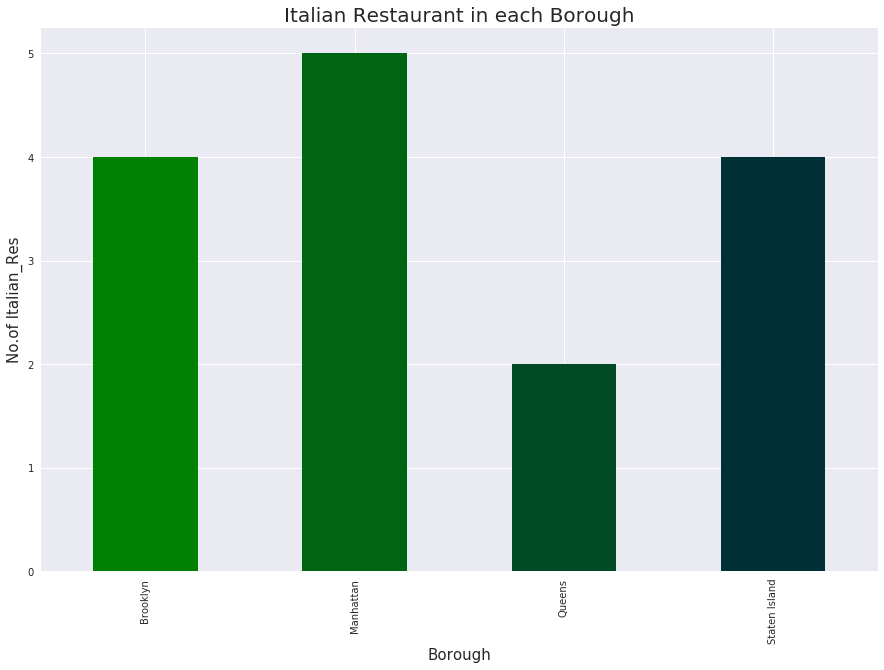

In [11]:
# visualise the content of the hontel dataframe using plot, showing the number of hetels in each borough of New York City
plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('seaborn')

color = plt.cm.ocean(np.linspace(0, 1, 15))
df_italian.groupby('Borough')['ID'].count().plot(kind='bar',color = color, figsize = (15, 10))

plt.title('Italian Restaurant in each Borough',fontsize = 20)
# x-axis
plt.xlabel('Borough', fontsize = 15)
#y-axis
plt.ylabel('No.of Italian_Res', fontsize=15)

plt.xticks(rotation = 90)
plt.show()

The plot above shows that 3 (Brooklyn, Manhattan, Queens and Staten Island)  out of 5 Borough have the same highest number of Italian Restaurant. Bronx is the all Borough in New York without Italian restaurant and Queens borough has only 20 Italian restaurants even though having the highest number of of neighborhoods. 

<h3><b>Let now evaluate Italian restaurants in each Borough </b></h3>

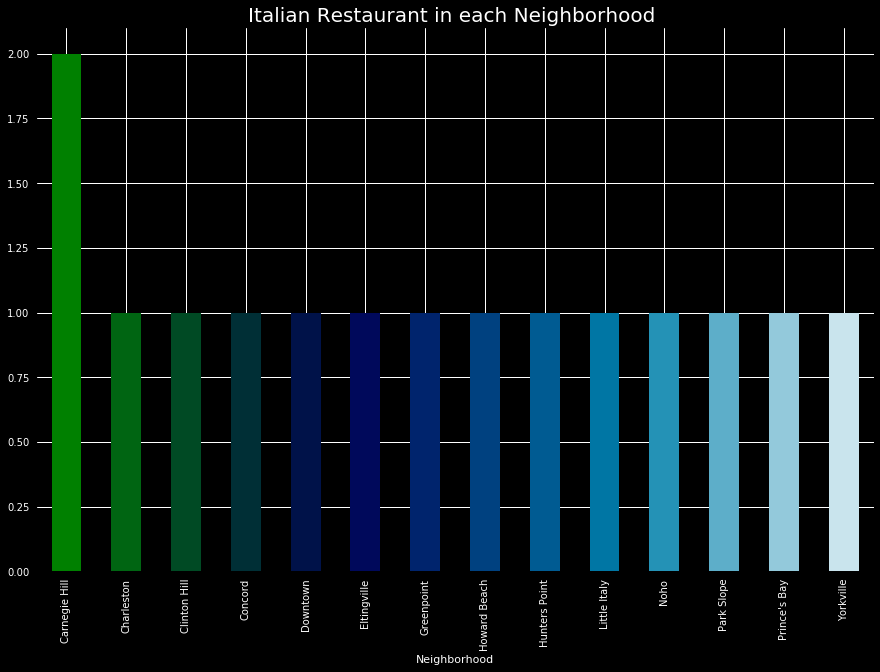

In [12]:
# plot major crimes acrross los Angeles Neighbourhood
plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('dark_background')

df_italian.groupby('Neighborhood')['ID'].count().plot(kind='bar',color = color, figsize = (15, 10))

plt.title('Italian Restaurant in each Neighborhood ', fontweight = 30, fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

Now we can conclude that the neighborhood with the highest number of Italian restaurant is Carnegie Hill

In [13]:
# evaluate each neighborhood conntaining Italian restaurant
res_li=pd.DataFrame(columns=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips'])
count=1

for row in df_italian.values.tolist():
    Borough,Neighborhood,ID,Name=row
# prepare neighborhood list that contains indian resturants

for row in df_italian.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(df_italian),')','processed')
    res_li = res_li.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 4ff37cb9e4b0b8fda883be7f
( 1 / 15 ) processed
No data available for id= 4d2ce735762fa143f40b7464
( 2 / 15 ) processed
No data available for id= 572d1d41498e2483c3bed970
( 3 / 15 ) processed
No data available for id= 59616e399ec399064afa985e
( 4 / 15 ) processed
No data available for id= 4a84af7ff964a52055fd1fe3
( 5 / 15 ) processed
No data available for id= 54f27deb498e47a670f5e399
( 6 / 15 ) processed
No data available for id= 4bafdb5df964a52086263ce3
( 7 / 15 ) processed
No data available for id= 4faee0e2e4b08260e41249d3
( 8 / 15 ) processed
No data available for id= 5b66428792e7a9002ca7cc7d
( 9 / 15 ) processed
No data available for id= 4aad53a2f964a520b75f20e3
( 10 / 15 ) processed
No data available for id= 4bb4d86886a8d13a83f8de7f
( 11 / 15 ) processed
No data available for id= 3fd66200f964a520d0e41ee3
( 12 / 15 ) processed
No data available for id= 4c07011e0e0a2d7ff9c7ec0c
( 13 / 15 ) processed
No data available for id= 4a1a3f6df964a5208b7a1fe3
( 14 / 15

In [14]:
res_li.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Greenpoint,0,0,0,0,0
1,Brooklyn,Park Slope,0,0,0,0,0
2,Brooklyn,Clinton Hill,0,0,0,0,0
3,Brooklyn,Downtown,0,0,0,0,0
4,Manhattan,Yorkville,0,0,0,0,0


<h3><b>Folium map of New York using latitude and longitude values</b></h3>

In [15]:
# get the latitude and logitude of New York City
address = 'New York, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude)) 

The geograpical coordinate of New York are 40.7127281, -74.0060152.


In [16]:
# create map of New York using latitude and longitude values
ny_map = folium.Map(location=[latitude, longitude], zoom_start=5)

In [17]:
df2 = pd.merge(df_italian, ny_data, on='Neighborhood')
df2.head()

,Borough_x,Neighborhood,ID,Name,Borough_y,Latitude,Longitude
0,Brooklyn,Greenpoint,4ff37cb9e4b0b8fda883be7f,Adelina's,Brooklyn,40.730201,-73.954241
1,Brooklyn,Park Slope,4d2ce735762fa143f40b7464,Da Nonna Rosa Cucina Italiana,Brooklyn,40.672321,-73.977050
2,Brooklyn,Clinton Hill,572d1d41498e2483c3bed970,Da Ciro Brooklyn,Brooklyn,40.693229,-73.967843
3,Brooklyn,Downtown,59616e399ec399064afa985e,Fortina,Brooklyn,40.690844,-73.983463
4,Manhattan,Yorkville,4a84af7ff964a52055fd1fe3,Arturo's,Manhattan,40.775930,-73.947118


In [18]:
for lat, lng,bor, neigh,res_name in zip(df2['Latitude'], df2['Longitude'], df2['Borough_x'],df2['Neighborhood'],df2['Name']):
    label = '{}'.format(res_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ny_map)  
    
ny_map

<h3> <b>Discussion </b></h3>

From this experiment we have identify 5 Borough of New York City those are Queens, Bronx, Brooklyn, Manhattan, and Staten Island. We have also identified Queens having more neighborhoods than the rest boroughs of New York. With that being said we have found that Queens has less or few number of Italian restaurant. On the other hand Bronx have no Italian restaurant in its neighborhood. Manhattan  has more Italian restaurant, while Brooklyn and Staten Island has equal number of Italian restaurant.

Recommended action:
1. For someone/ business that wants to open an Italian restaurant the best best places would be Queens since it more populated while the number of Italian restaurant are less or few compared to other regions and another one is Bronx since it has non Italian restaurants.

2. For a visiting individual the variate Italian restaurants are in Manhattan, Brooklyn, and Staten Island.


<h3> <b>Conclusion </b></h3>

The experiment help us compare neighborhoods of New York with result and Facts!
